## Important library

In [1]:
import numpy as np
import random

np.random.seed(42)
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## 1. Load Dataset 

In [2]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n, d = X_train.shape
print(f"Training lenght : {X_train.shape}, Test lenght : {X_test.shape}")

Taille d'entraînement : (353, 10), Taille de test : (89, 10)


## 2. Implementations

### 2.1 Ridge Regression

In [3]:
def ridge_loss(w, X, y, lbda):
    n = X.shape[0]
    return 0.5/n * np.sum((X.dot(w) - y)**2) + 0.5 * lbda * np.sum(w**2)

def ridge_grad(w, X, y, lbda):
    n = X.shape[0]
    return (1.0/n) * X.T.dot(X.dot(w) - y) + lbda * w

# SGD for Ridge Regression
def sgd_ridge(w0, X, y, lbda, steps, n_iter):
    n = X.shape[0]
    w = w0.copy()
    loss_hist = [ridge_loss(w, X, y, lbda)]
    indices = np.random.randint(0, n, n_iter)
    for k in range(n_iter):
        i = indices[k]
        w = w - steps[k] * ridge_grad(w, X[i:i+1, :], y[i:i+1], lbda)
        if k % 100 == 0:
            loss_hist.append(ridge_loss(w, X, y, lbda))
    # Get solution from L-BFGS
    w_star, obj_star, _ = fmin_l_bfgs_b(lambda w: ridge_loss(w, X, y, lbda), w0, lambda w: ridge_grad(w, X, y, lbda), pgtol=1e-30, factr=1e-30)
    loss_hist = np.array(loss_hist) - ridge_loss(w_star, X, y, lbda)
    return w, loss_hist

# SAG for Ridge Regression
def sag_ridge(w0, X, y, lbda, step, n_iter, store_every=100):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    # Get solution from L-BFGS
    w_star, obj_star, _ = fmin_l_bfgs_b(lambda w: ridge_loss(w, X, y, lbda), w0, lambda w: ridge_grad(w, X, y, lbda), pgtol=1e-30, factr=1e-30)
    # Stockage des gradients individuels
    grad_memory = np.zeros((n, d))
    averaged_grad = np.zeros(d)
    indices = np.random.randint(0, n, n_iter)
    for k in range(n_iter):
        i = indices[k]
        averaged_grad -= grad_memory[i] / n
        grad_memory[i] = ridge_grad(w, X[i:i+1, :], y[i:i+1], lbda)
        averaged_grad += grad_memory[i] / n
        w = w - step * averaged_grad
        if k % store_every == 0:
            loss_hist.append(ridge_loss(w, X, y, lbda) - ridge_loss(w_star, X, y, lbda))
    return w, np.array(loss_hist)

# SAGA for Ridge Regression
def saga_ridge(w0, X, y, lbda, step, n_iter, store_every=100):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    w_star, obj_star, _ = fmin_l_bfgs_b(lambda w: ridge_loss(w, X, y, lbda), w0, lambda w: ridge_grad(w, X, y, lbda), pgtol=1e-30, factr=1e-30)
    grad_memory = np.zeros((n, d))
    averaged_grad = np.zeros(d)
    indices = np.random.randint(0, n, n_iter)
    for k in range(n_iter):
        i = indices[k]
        new_grad = ridge_grad(w, X[i:i+1, :], y[i:i+1], lbda)
        w = w - step * (new_grad - grad_memory[i] + averaged_grad)
        averaged_grad += (new_grad - grad_memory[i]) / n
        grad_memory[i] = new_grad
        if k % store_every == 0:
            loss_hist.append(ridge_loss(w, X, y, lbda) - ridge_loss(w_star, X, y, lbda))
    return w, np.array(loss_hist)

# SVRG for Ridge Regression
def svrg_ridge(w0, X, y, lbda, step, n_outer, n_inner):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    # Get solution from L-BFGS
    w_star, obj_star, _ = fmin_l_bfgs_b(lambda w: ridge_loss(w, X, y, lbda), w0, lambda w: ridge_grad(w, X, y, lbda), pgtol=1e-30, factr=1e-30)
    for outer in range(n_outer):
        full_grad = ridge_grad(w, X, y, lbda)
        w_tilde = w.copy()
        indices = np.random.randint(0, n, n_inner)
        for i in indices:
            grad_w = ridge_grad(w, X[i:i+1, :], y[i:i+1], lbda)
            grad_tilde = ridge_grad(w_tilde, X[i:i+1, :], y[i:i+1], lbda)
            w = w - step * (grad_w - grad_tilde + full_grad)
        loss_hist.append(ridge_loss(w, X, y, lbda) - ridge_loss(w_star, X, y, lbda))
    return w, np.array(loss_hist)

### 2.2 Lasso

In [4]:
def lasso_loss(w, X, y, lbda):
    n = X.shape[0]
    return 0.5/n * np.sum((X.dot(w) - y)**2) + lbda * np.sum(np.abs(w))

def lasso_grad(w, X, y):
    n = X.shape[0]
    return (1.0/n) * X.T.dot(X.dot(w) - y)

def prox_l1(w, thresh):
    return np.sign(w) * np.maximum(np.abs(w) - thresh, 0)

# Proximal SGD for Lasso
def prox_sgd_lasso(w0, X, y, lbda, steps, n_iter):
    w = w0.copy()
    loss_hist = [lasso_loss(w, X, y, lbda)]
    for k in range(n_iter):
        grad_val = lasso_grad(w, X, y)
        w = w - steps[k] * grad_val
        w = prox_l1(w, steps[k]*lbda)
        if k % 50 == 0:
            loss_hist.append(lasso_loss(w, X, y, lbda))
    # Get solution from L-BFGS (only using the quadratic term, and prox for post-analysis)
    # Hint : For Lasso, we can't get exact solution directly from L-BFGS without a specific analysis.
    return w, np.array(loss_hist)

# Using the proximal term as regularization term to handle lasso problem
def prox_sag_lasso(w0, X, y, lbda, step, n_iter, store_every=100):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    grad_memory = np.zeros((n, d))
    averaged_grad = np.zeros(d)
    indices = np.random.randint(0, n, n_iter)
    for k in range(n_iter):
        i = indices[k]
        averaged_grad -= grad_memory[i] / n
        grad_memory[i] = lasso_grad(w, X[i:i+1, :], y[i:i+1])
        averaged_grad += grad_memory[i] / n
        w = w - step * averaged_grad
        w = prox_l1(w, step*lbda)
        if k % store_every == 0:
            loss_hist.append(lasso_loss(w, X, y, lbda))
    return w, np.array(loss_hist)

def prox_saga_lasso(w0, X, y, lbda, step, n_iter, store_every=100):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    grad_memory = np.zeros((n, d))
    averaged_grad = np.zeros(d)
    indices = np.random.randint(0, n, n_iter)
    for k in range(n_iter):
        i = indices[k]
        new_grad = lasso_grad(w, X[i:i+1, :], y[i:i+1])
        w = w - step * (new_grad - grad_memory[i] + averaged_grad)
        averaged_grad += (new_grad - grad_memory[i]) / n
        grad_memory[i] = new_grad
        w = prox_l1(w, step*lbda)
        if k % store_every == 0:
            loss_hist.append(lasso_loss(w, X, y, lbda))
    return w, np.array(loss_hist)

def prox_svrg_lasso(w0, X, y, lbda, step, n_outer, n_inner):
    n, d = X.shape
    w = w0.copy()
    loss_hist = []
    for outer in range(n_outer):
        full_grad = lasso_grad(w, X, y)
        w_tilde = w.copy()
        indices = np.random.randint(0, n, n_inner)
        for i in indices:
            grad_w = lasso_grad(w, X[i:i+1, :], y[i:i+1])
            grad_tilde = lasso_grad(w_tilde, X[i:i+1, :], y[i:i+1])
            w = w - step * (grad_w - grad_tilde + full_grad)
            w = prox_l1(w, step*lbda)
        loss_hist.append(lasso_loss(w, X, y, lbda))
    return w, np.array(loss_hist)

## 3 Results

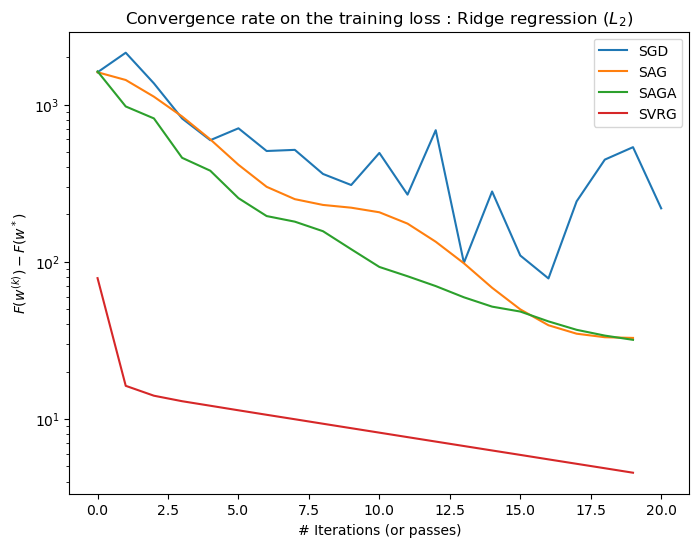

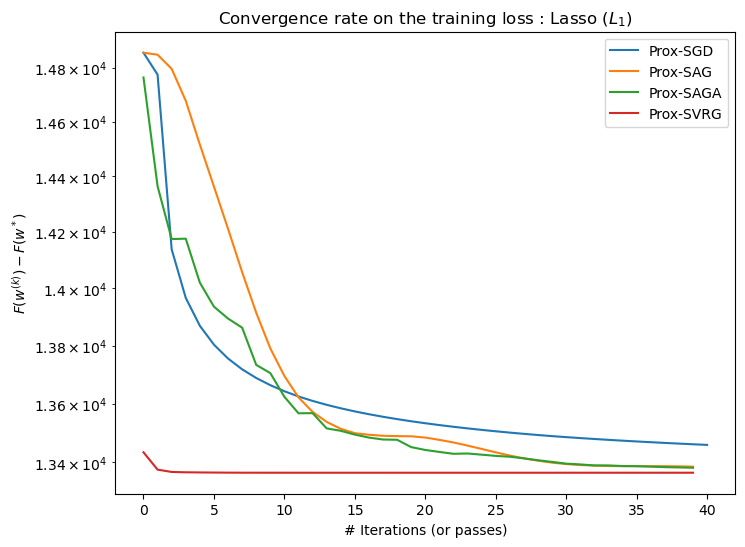

In [5]:

np.random.seed(42)

# Parameters for Ridge Regression
lbda_ridge = 1e-5
w0_ridge = np.zeros(d)
max_iter = 2000
steps = [1e-1/np.sqrt(t+1) for t in range(max_iter)]

# Parameters for Lasso
lbda_lasso = 1.0
w0_lasso = np.zeros(d)
max_iter_lasso = 2000
steps_lasso = [1e-2/np.sqrt(t+1) for t in range(max_iter_lasso)]

#===========================================
#                  Ridge
#===========================================


# Load SGD
w_sgd, loss_sgd = sgd_ridge(w0_ridge, X_train, y_train, lbda_ridge, steps, max_iter)

# Load  SAG
w_sag, loss_sag = sag_ridge(w0_ridge, X_train, y_train, lbda_ridge, step=1e-3, n_iter=max_iter, store_every=100)

# Load  SAGA
w_saga, loss_saga = saga_ridge(w0_ridge, X_train, y_train, lbda_ridge, step=1e-3, n_iter=max_iter, store_every=100)

# Load  SVRG (with 20 passes, and n_inner = n)
w_svrg, loss_svrg = svrg_ridge(w0_ridge, X_train, y_train, lbda_ridge, step=1e-2, n_outer=20, n_inner=n)

#=============================================
#                   Lasso
#=============================================
# Load  Proximal SGD for Lasso
w_psgd, loss_psgd = prox_sgd_lasso(w0_lasso, X_train, y_train, lbda_lasso, steps_lasso, max_iter_lasso)

# Load  Proximal SAG for Lasso
w_psag, loss_psag = prox_sag_lasso(w0_lasso, X_train, y_train, lbda_lasso, step=1e-3, n_iter=max_iter_lasso, store_every=50)

# Load  Proximal SAGA for Lasso
w_psaga, loss_psaga = prox_saga_lasso(w0_lasso, X_train, y_train, lbda_lasso, step=1e-3, n_iter=max_iter_lasso, store_every=50)

# Load  Proximal SVRG for Lasso (with 40 passes, and n_inner = n)
w_psvrg, loss_psvrg = prox_svrg_lasso(w0_lasso, X_train, y_train, lbda_lasso, step=1e-2, n_outer=40, n_inner=n)

#============================================
#                   Output
#============================================

plt.figure(figsize=(8,6))
plt.semilogy(loss_sgd, label='SGD')
plt.semilogy(loss_sag, label='SAG')
plt.semilogy(loss_saga, label='SAGA')
plt.semilogy(loss_svrg, label='SVRG')
plt.xlabel('# Iterations (or passes)')
plt.ylabel("$F(w^{(k)})-F(w^*)$")
plt.title('Convergence rate on the training loss : Ridge regression ($L_2$)')
plt.legend()
plt.savefig("RidgeTrain.pdf")
plt.show()


plt.figure(figsize=(8,6))
plt.semilogy(loss_psgd, label='Prox-SGD')
plt.semilogy(loss_psag, label='Prox-SAG')
plt.semilogy(loss_psaga, label='Prox-SAGA')
plt.semilogy(loss_psvrg, label='Prox-SVRG')
plt.xlabel("# Iterations (or passes)")
plt.ylabel("$F(w^{(k)})-F(w^*)$")
plt.title("Convergence rate on the training loss : Lasso ($L_1$)")
plt.legend()
plt.savefig("LassoTrain.pdf")
plt.show()
